This notebook will present an example of VRP with Time and Capacity constraints using OR-tools.

## Importing the libraries

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
from datetime import datetime, timedelta
import random as rd
from collections import namedtuple

## Defining the list of vehicles

Each vehicle has a capacity. The capacity is the maximum number of items that can be stored in the vehicle.

In [7]:
class Vehicles:
    def __init__(self, capacity):
        # capacity is a list containing the maximum number of items that can be stored in each vehicle.

        # Defining the categories of the tuple
        Vehicle = namedtuple('Vehicle', ['Vehicle_Index', 'Vehicle_Capactiy'])

        # Getting the number of vehicles
        self.Number_of_Vehicles = np.size(capacity)

        # Getting the total capacity of all vehicles
        self.Total_Capacity = np.sum(capacity)

        # Creating the list of vehicles
        self.Vehicles = [Vehicle(i, capacity[i]) for i in range(self.Number_of_Vehicles)]

    def set_start_end_points(self, depot):
        self.start_point = depot
        self.end_point = depot


## Defining the list of distribution points

Each distribution point is represented by a city. Each city has a time window for delivery and a capacity. The time window is defined by a start time and an end time. The capacity is the maximum number of items that have to be delivered in a time window.

In [8]:
class Distribution_Points:
    def __init__(self, nb_stops=10, min_capacity_asked=1, max_capacity_asked=5, min_time_window=1, max_time_window=5):
        self.nb_stops = nb_stops
        City_Name = namedtuple('City', ['lattitude', 'longitude'])
        # Creation of the field of work (using approx geolocation of Grand Est)
        LowerLeft_Corner = (47.580851, 3.616464)
        UpperRight_Corner = (49.668615, 8.357526)

        # Setting the center of field for the first depot
        self.center_of_field = City_Name(UpperRight_Corner[0] - (UpperRight_Corner[0] - LowerLeft_Corner[0]) / 2, UpperRight_Corner[1] - (UpperRight_Corner[1] - LowerLeft_Corner[1]) / 2)

        list_of_stops = np.array(range(0, self.nb_stops))
        list_of_latitudes = (LowerLeft_Corner[0] + np.random.randn(self.nb_stops) *
                (UpperRight_Corner[0] - LowerLeft_Corner[0]) )
        list_of_longitudes = (LowerLeft_Corner[1] + np.random.randn(self.nb_stops) *
                (UpperRight_Corner[1] - LowerLeft_Corner[1]) )


        # Generating random capacities asked and random time windows
        list_of_capacities = np.random.randint(min_capacity_asked, max_capacity_asked, self.nb_stops)
        list_of_time_windows = np.random.randint(min_time_window*60, max_time_window*60, self.nb_stops)

        # Time window of a day of work (8h - 20h)
        self.work_time_window = 12 * 60

        latest_delivery_time = self.work_time_window - list_of_time_windows
        beginning_times = [None for i in list_of_time_windows]
        ending_times = [None for i in list_of_time_windows]

        for i in range(self.nb_stops):
            # Generating random time windows
            beginning_times[i] = timedelta(minutes=np.random.randint(0, latest_delivery_time[i]))
            ending_times[i] = beginning_times[i] + timedelta(minutes=int(list_of_time_windows[i]))

        # Generating Delivery Points
        Distribution_Point = namedtuple('Delivery_Point', ['index', 'lattitude', 'longitude', 'capacity', 'time_window_beginning', 'time_window_ending'])
        self.Distribution_Points = [Distribution_Point(i,
                                                       list_of_latitudes[i],
                                                       list_of_longitudes[i],
                                                       list_of_capacities[i],
                                                       beginning_times[i],
                                                       ending_times[i]) for i in range(self.nb_stops)]

        # Calculating total capacity
        self.Total_Capacity = np.sum([self.Distribution_Points[i].capacity for i in range(self.nb_stops)])

    def calculate_haversine_distance(self, lat1, lon1, lat2, lon2):
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)
        """
        # convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        # haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        r = 6371 # Radius of earth in kilometers. Use 3956 for miles
        return c * r

    def calculate_distance_matrix(self):
        # Calculating the distance matrix
        self.distance_matrix = np.zeros((self.nb_stops, self.nb_stops))
        for i in range(self.nb_stops):
            for j in range(self.nb_stops):
                self.distance_matrix[i, j] = self.calculate_haversine_distance(self.Distribution_Points[i].lattitude, self.Distribution_Points[i].longitude, self.Distribution_Points[j].lattitude, self.Distribution_Points[j].longitude)
        return self.distance_matrix

    def calculate_time_matrix(self):
        # Set the speed of the vehicle at 50 km/h
        self.speed = 50
        self.time_matrix = np.zeros((self.nb_stops, self.nb_stops))
        for i in range(self.nb_stops):
            for j in range(self.nb_stops):
                self.time_matrix[i, j] = self.distance_matrix[i, j] / self.speed * 60 # in minutes
        return self.time_matrix

    def define_depots(self, vehicles):
        self.depots = rd.sample(range(1, self.nb_stops), vehicles.Number_of_Vehicles)
        for depot in self.depots:
            temp_replacement = self.Distribution_Points[depot]
            self.Distribution_Points[depot] = temp_replacement._replace(capacity=0, time_window_beginning=None, time_window_ending=None)
        vehicles.set_start_end_points(self.depots)
        return self.depots

    def implements_manager(self, manager):
        self.routing_manager = manager

    def distance_between_distribution_points_callback(self):
        # Creates callback to return distance between points
        # Creates the distance matrix
        self.calculate_distance_matrix()

        def return_distance(fi, ti):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_distribution_point = self.routing_manager.IndexToNode(fi)
            to_distribution_point = self.routing_manager.IndexToNode(ti)
            return self.distance_matrix[from_distribution_point][to_distribution_point]

        return return_distance

    def time_between_distribution_points_callback(self):
        # Creates callback to return time between points
        # Creates the time matrix
        self.calculate_time_matrix()

        def return_time(fi, ti):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_distribution_point = self.routing_manager.IndexToNode(fi)
            to_distribution_point = self.routing_manager.IndexToNode(ti)
            return self.time_matrix[from_distribution_point][to_distribution_point]

        return return_time

    def capacity_callback(self):

        def return_capacity(fi):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_distribution_point = self.routing_manager.IndexToNode(fi)
            return self.Distribution_Points[from_distribution_point].capacity

        return return_capacity

Left to implement :
- Time spent at each delivery point for each vehicle (randomized ? between  3 and 5 minutes per delivery ? or per quantity ?)
-

## Plotting functions


In [9]:
def get_vehicle_output(routing_manager_output, routing_output, plan):
    """
    Get the vehicle output for each vehicle. I have to trust Copilot for this one.
    """

    dropped_points = []
    for point in range(routing_output.Size()):
        if plan.Value(routing_output.NextVar(point)) == point:
            dropped_points.append(str(point))

    capacity_dimension_output  = routing_output.GetDimensionOrDie('Capacity')
    duration_dimension_output = routing_output.GetDimensionOrDie('Time')
    plan_output_output  = ''

    for route in range(routing_output.vehicles()):
        index = routing_output.Start(route)
        plan_output_output  += 'Route for vehicle {}:\n'.format(route)
        while not routing_output.IsEnd(index):
            load_var = capacity_dimension_output.CumulVar(index)
            time_var = duration_dimension_output.CumulVar(index)
            point_index = routing_manager_output.IndexToNode(index)
            plan_output_output  += \
                    ' Point n°{node} Load({load}) Time({tmin}, {tmax}) -> '.format(
                        node=point_index,
                        load=plan.Value(load_var),
                        tmin=str(timedelta(minutes=plan.Min(time_var))),
                        tmax=str(timedelta(minutes=plan.Max(time_var))))
            index = plan.Value(routing_output.NextVar(index))
            if routing_output.IsEnd(index):
                plan_output_output += ' EndRoute {0}. \n'.format(route)
                break
        plan_output_output += '\n'
    return plan_output_output, dropped_points

def create_vehicle_path(routing_manager, routing, plan, distribution_points, vehicle_index):
    # Get if current vehicle is used
    is_vehicle_used = routing.IsVehicleUsed(plan, vehicle_index)
    # If it is, add path
    if is_vehicle_used:
        vehicle_path = []
        current_point = routing.Start(vehicle_index)
        vehicle_path.append(distribution_points[routing_manager.IndexToNode(current_point)])
        while not routing.IsEnd(current_point):
            vehicle_path.append(distribution_points[routing_manager.IndexToNode(current_point)])
            current_point = plan.Value(routing.NextVar(current_point))
        vehicle_path.append(distribution_points[routing_manager.IndexToNode(current_point)])
        return vehicle_path
    else:
        return None

def plot_vehicle_path(vehicle_path, axis, distribution_points, vehicles):
    list_of_used_vehicles = [i for i in vehicle_path if vehicle_path[i] is not None]

    #Create the map
    base = plt.cm.get_cmap('nipy_spectral')
    color_list = base(np.linspace(0, 1, vehicles.Number_of_Vehicles+2))
    cmap_name = base.name + str(vehicles.Number_of_Vehicles+2)

    cmap = base.from_list(cmap_name, color_list, vehicles.Number_of_Vehicles+2)

    for vehicle_index in list_of_used_vehicles:
        lats, lons = zip(*[(point.lattitude, point.longitude) for point in vehicle_path[vehicle_index]])
        lats = np.array(lats)
        lons = np.array(lons)
        start_point = distribution_points.Distribution_Points[vehicles.start_point[vehicle_index]]
        end_point = distribution_points.Distribution_Points[vehicles.end_point[vehicle_index]] #End point is the same because we go back to the start point

        #Plot the path
        axis.annotate(
            'Vehicle ({veh}) Starting @ {node}'.format(
                veh=vehicle_index, node=vehicles.start_point[vehicle_index]),
            xy=(start_point.longitude, start_point.lattitude),
            xytext=(10, 10),
            xycoords='data',
            textcoords='offset points',
            arrowprops=dict(
                arrowstyle='->',
                connectionstyle='angle3,angleA=90,angleB=0',
                shrinkA=0.05),
        )
        axis.plot(lons, lats, 'o', mfc=cmap(vehicle_index + 1))
        axis.quiver(
            lons[:-1],
            lats[:-1],
            lons[1:] - lons[:-1],
            lats[1:] - lats[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=cmap(vehicle_index + 1))


## Execute the algorithm

Route for vehicle 0:
 Point n°66 Load(0) Time(0:00:00, 0:00:00) ->  Point n°84 Load(0) Time(0:29:00, 3:14:00) ->  Point n°79 Load(38) Time(2:16:00, 4:35:00) ->  Point n°78 Load(62) Time(8:45:00, 9:47:00) ->  Point n°60 Load(129) Time(8:45:00, 9:47:00) ->  EndRoute 0. 

Route for vehicle 1:
 Point n°7 Load(0) Time(0:00:00, 0:00:00) ->  EndRoute 1. 

Route for vehicle 2:
 Point n°88 Load(0) Time(0:00:00, 0:00:00) ->  Point n°98 Load(0) Time(3:52:00, 4:52:00) ->  Point n°96 Load(30) Time(3:59:00, 6:27:00) ->  EndRoute 2. 

Route for vehicle 3:
 Point n°62 Load(0) Time(0:00:00, 0:00:00) ->  Point n°68 Load(0) Time(3:16:00, 4:18:00) ->  Point n°59 Load(32) Time(3:40:00, 5:58:00) ->  Point n°52 Load(53) Time(5:38:00, 8:03:00) ->  EndRoute 3. 

Route for vehicle 4:
 Point n°35 Load(0) Time(0:00:00, 0:00:00) ->  Point n°21 Load(0) Time(4:10:00, 4:34:00) ->  Point n°18 Load(53) Time(4:10:00, 4:34:00) ->  Point n°3 Load(100) Time(4:10:00, 7:06:00) ->  EndRoute 4. 

Route for vehicle 5:
 Point n°

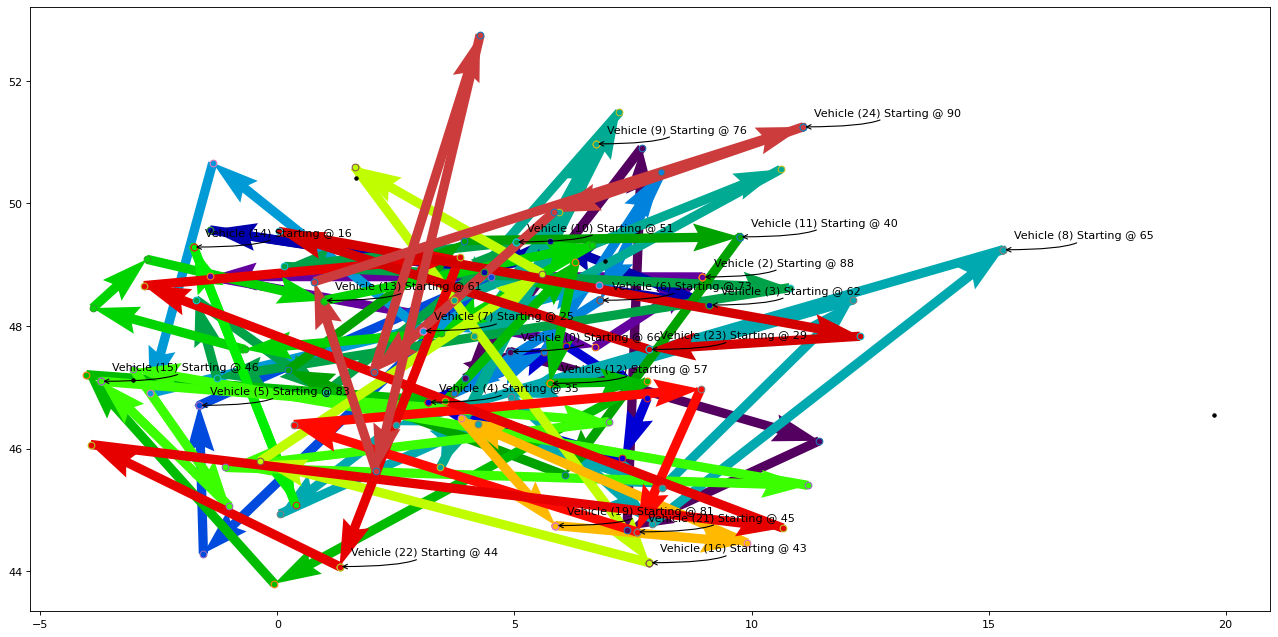

In [10]:
# Creating the list of distribution points
list_of_distribution_points = Distribution_Points(nb_stops=100,
                                                  min_capacity_asked=1,
                                                  max_capacity_asked=75,
                                                  min_time_window=1,
                                                  max_time_window=3)

# Creating the list of vehicles
nb_vehicles = 25
list_of_capacities = [rd.randrange(25, 250, 5) for i in range(nb_vehicles)]
list_of_vehicles = Vehicles(capacity=list_of_capacities)

# Verifying that the total capacity of the vehicles is higher than the total capacity of the distribution points
if list_of_vehicles.Total_Capacity < list_of_distribution_points.Total_Capacity:
    print("The total capacity of the vehicles is not enough to transport all the demand")
    print("The total capacity of the vehicles is : ", list_of_vehicles.Total_Capacity)
    print("The total capacity asked by the distribution points is : ", list_of_distribution_points.Total_Capacity)
    exit()
else:

    # Creating the list of depots
    list_of_distribution_points.define_depots(list_of_vehicles)

    # Creating the Google Routing Manager with default parameters
    routing_manager = pywrapcp.RoutingIndexManager(list_of_distribution_points.nb_stops,
                                                   list_of_vehicles.Number_of_Vehicles,
                                                   list_of_vehicles.start_point,
                                                   list_of_vehicles.end_point)
    routing_manager_model_parameters = pywrapcp.DefaultRoutingModelParameters()

    # Adding the manager to the list of distribution points
    list_of_distribution_points.implements_manager(routing_manager)

    # Set up the routing instance
    routing = pywrapcp.RoutingModel(routing_manager, routing_manager_model_parameters)

    # Using default parameters provided by Google
    parameters = pywrapcp.DefaultRoutingSearchParameters()
    # Setting first solution heuristic (cheapest addition).
    parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    parameters.time_limit.seconds = 10
    parameters.use_full_propagation = True

    # Call callbacks and add them to the routing model
    distance_callback_function = list_of_distribution_points.distance_between_distribution_points_callback()
    distance_callback_function_index = routing.RegisterTransitCallback(distance_callback_function)

    capacity_callback_function = list_of_distribution_points.capacity_callback()
    capacity_callback_function_index = routing.RegisterUnaryTransitCallback(capacity_callback_function)

    transport_time_function = list_of_distribution_points.time_between_distribution_points_callback()
    transport_time_function_index = routing.RegisterTransitCallback(transport_time_function)

    # Adding the capacity dimension as per https://developers.google.com/optimization/routing/dimensions
    routing.AddDimensionWithVehicleCapacity(capacity_callback_function_index,
                         0,
                         list_of_capacities,
                         True,
                         "Capacity")

    # Adding the time dimension as per https://developers.google.com/optimization/routing/dimensions
    routing.AddDimension(transport_time_function_index,
                         list_of_distribution_points.work_time_window,
                         list_of_distribution_points.work_time_window,
                         True,
                         "Time")

    duration_dimension = routing.GetDimensionOrDie("Time")
    for distribution_point in list_of_distribution_points.Distribution_Points:
        if distribution_point.time_window_beginning is not None:
            duration_dimension.CumulVar(routing_manager.NodeToIndex(distribution_point.index)).SetRange(
                int(distribution_point.time_window_beginning.seconds/60),
                int(distribution_point.time_window_ending.seconds/60))

    # Well, let's try solving it.
    solving = routing.SolveWithParameters(parameters)
    if solving:
        # Display the solution.
        #print('Total distance of the solution: {}m'.format(solving.GetObjectiveValue()))
        plan_output, dropped_points = get_vehicle_output(routing_manager, routing, solving)
        print(plan_output)
        print('Dropped points: ' + ', '.join(dropped_points))

        list_of_routes = {}
        for vehicle in range(list_of_vehicles.Number_of_Vehicles):
            list_of_routes[vehicle] = create_vehicle_path(routing_manager, routing, solving, list_of_distribution_points.Distribution_Points, vehicle)

        # Crates the plot
        result_figure = plt.figure(figsize=(20, 10), dpi=80)
        axs = result_figure.add_subplot(111)
        # Plot the points
        clon, clat = zip(*[(point.longitude, point.lattitude) for point in list_of_distribution_points.Distribution_Points])
        axs.plot(clon, clat, 'k.')
        # Plot the routes
        plot_vehicle_path(list_of_routes, axs, list_of_distribution_points, list_of_vehicles)
        plt.show()
    else:
        print('No solution found.')